In [1]:
# import modules for math and distributions
from math import exp
import numpy as np
from scipy.stats import gamma, norm, uniform, bernoulli
import pandas as pd
import statsmodels.api as sm
import rpy2
import patsy
import pdb

In [2]:
# required to be able to work with rpy2
%load_ext rpy2.ipython

In [3]:
# define inverse logit (expit) function
def expit(x): return(exp(x)/(1 + exp(x)))

In [4]:
# Initial set up following HD2012
T = 40 # time periods
k = 5 # check-up times
theta = [-0.405, 0.0205, -0.00405]
gam = [-3, 0.05, -1.5, 0.1]

In [5]:
# make a function that does all of the above for an individual
def sim(T, k, gam, theta, patid=0):

    # define lists for holding A, L, U and Y
    A = -1*np.ones(T + 2) # A[-1] (last value) holds A in t = -1
    L = np.zeros(T+1)
    U = np.zeros(T+1)
    Y = -1*np.ones(T + 2)
    eps = np.zeros(T+1)
    lam = np.zeros(T+1) # prob of failure at each time period
    delta = np.zeros(T+1)

    # set the first value of U, U[0], to a 
    # randomly generated value from a uniform
    # distribution a measure of general health
    U[0] = uniform.rvs()
    eps[0] = norm.rvs(0, 20)
    L[0] = gamma.ppf(U[0], 3, scale=154) + eps[0]
    # L[0] = max(0, gamma.ppf(U[0], 3, scale=154) + eps[0])

    # set A[-1] to 0: held in last value of A
    A[-1] = 0
    Y[0] = 0
    
    # set A[0]
    A[0] = bernoulli.rvs(expit(theta[0] + theta[2] * (L[0] - 500)), size=1)
    
    if A[0] == 1:
        Ts = 0 
    else:
        Ts = -1
    
    lam[0] = expit(gam[0] + gam[2] * A[0])
    
    if lam[0] >= U[0]:
        Y[1] = 1
    else:
        Y[1] = 0
    # loop through each time period - stop when patient is dead or t = T + 1
    for t in range(1, T+1):
        if Y[t] == 0:
            delta[t] = norm.rvs(0, 0.05)
            U[t] = min(1, max(0, U[t-1] + delta[t]))
            if t % k != 0:
                L[t] = L[t-1]
                A[t] = A[t-1]
            else:
                eps[t] = norm.rvs(100 * (U[t] - 2), 50)
                L[t] = max(0, L[t-1] + 150 * A[t-k] * (1-A[t-k-1]) + eps[t])
                if A[t-1] == 0:
                    A[t] = bernoulli.rvs(expit(theta[0] + theta[1] * t + theta[2] * (L[t] - 500)), size=1)
                else:
                    A[t] = 1
                if A[t] == 1 and A[t-k] == 0: 
                    Ts = t
            ########################################
            # This is a check for debugging purposes
            # Comment it before the next push
            if Ts == -1:
                if A[t]:
                    print('There is an error...')
            ########################################
            lam[t] = expit(gam[0] + gam[1] * ((1 - A[t]) * t + A[t] * Ts) + gam[2] * A[t] + gam[3] * A[t] *(t - Ts))
            if (1 - np.prod(1 - lam)) >= U[0]:
                Y[t + 1] = 1
            else:
                Y[t+1] = 0
        else:
            break
    
    #we only need the data before death, so whatever value t is before the end of the
    #above loop - change this to numpy array and transpose.
    Y = np.ndarray.tolist(Y[1:(t+1)])
    U = np.ndarray.tolist(U[0:t])
    L = np.ndarray.tolist(L[0:t])
    A = np.ndarray.tolist(A[0:t])
    Ts = [Ts]*t

    df = np.vstack((Y, L, U, A, Ts))
    df = pd.DataFrame(df.T, columns=['Y', 'L', 'U', 'A', 'Ts'])
    df['Y'] = df['Y'].astype(int)
    df['A'] = df['A'].astype(int)
    df['patid'] = patid
    df.index.name = 'visit'
    return df.reset_index()

In [6]:
# use sim function to make a pandas DF for n patients
def get_sim_data(T, k, gam, theta, n = 1000):

    # get data for each of 1000 patients
    frames = [sim(T, k, gam, theta, patid=i) for i in range(n)]
    df = pd.concat(frames)
    # make new variables for the logit regression
    # including an intercept
    df["d1"] = (1-df['A'])*df['visit'] + df['A']*df['Ts']
    df["d3"] = df['A']*(df['visit']-df['Ts'])
    # df["time_Ts"] = df["visit"] - df["Ts"]
    df = df.set_index(['patid', 'visit'])
    df = df.sort_index()
    
    #create two new variables 
    df["L_100"] = df["L"]/100
    def func(x):
        x["Lav_100"] = x["L"].mean()/100
        return x

    df = df.groupby(level="patid").apply(func)
    
    # get the previous value of A, and set first value of A_1 per patient to zero.
    df['A_1'] = df.groupby(level="patid")['A'].shift(1)
    df['A_1'] = df['A_1'].fillna(0)

    return(df)

In [7]:
def get_weights(df):
    
    # only need data when A is not 1 yet
    df["As"] = df.groupby(level="patid")['A'].cumsum()
    df2 = df[df["As"] <= 1].copy(deep=True)

    # numerator
    f = "A ~ 1"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    n_logit = sm.Logit(y, X, missing="raise")
    n_result = n_logit.fit(disp=0, maxiter=100)
    df2["pn"] = n_result.predict()
    
    # denominator
    f = "A ~ L"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    d_logit = sm.Logit(y, X, missing="raise")
    d_result = d_logit.fit(disp=0, maxiter=100)
    df2["pd"] = d_result.predict()

    # if A == 0, change probabilities to 1 - prob
    df2['pn2'] = np.where(df2['A']==0, (1 - df2["pn"]), df2["pn"])
    df2['pd2'] = np.where(df2['A']==0, (1 - df2["pd"]), df2["pd"])

    # construct stabilized weights, don't forget to group by
    df2['cpn'] = df2.groupby(level=0)['pn2'].cumprod()
    df2['cpd'] = df2.groupby(level=0)['pd2'].cumprod()
    df2['sw'] = df2['cpn']/df2['cpd']

    #combine df and df2
    df["sw"] = np.nan
    df.loc[df2.index, "sw"] = df2["sw"]
    df["sw"] = df["sw"].fillna(method="pad")
    
    return(df)


In [8]:
df = get_sim_data(T, k, gam, theta, n = 1000)
df = get_weights(df)

In [9]:
tmp = df.reset_index()
tmp.head()

,patid,visit,Y,L,U,A,Ts,d1,d3,L_100,Lav_100,A_1,As,sw
0,0,0,0,468.471568,0.590632,0,5.0,0.0,-0.0,4.684716,3.283085,0.0,0,1.001832
1,0,1,0,468.471568,0.612924,0,5.0,1.0,-0.0,4.684716,3.283085,0.0,0,1.003668
2,0,2,0,468.471568,0.666282,0,5.0,2.0,-0.0,4.684716,3.283085,0.0,0,1.005507
3,0,3,0,468.471568,0.631485,0,5.0,3.0,-0.0,4.684716,3.283085,0.0,0,1.007350
4,0,4,0,468.471568,0.636759,0,5.0,4.0,-0.0,4.684716,3.283085,0.0,0,1.009195


In [10]:
%%R -i tmp -o co
library(ipw)
library(survey)
tmp$tstart <- tmp$visit - 1
co <- matrix(NA, nrow= 100, ncol = 4)
ipwsw <- ipwtm(exposure = A, family = "survival",
               numerator = ~ 1, denominator = ~ L,
               id = patid, timevar = visit, tstart = tstart,
               type = "first", data = tmp)
tmp$ipwsw <- ipwsw$ipw.weights
desipw <- svydesign(ids = ~ 1, data = tmp, weights = ~ ipwsw)
mdl <- svyglm(Y ~ d1 + A + d3, design = desipw, family = quasibinomial())
co <- coef(mdl)
print(summary(mdl))

In [11]:
co

array([-2.88981559,  0.03556863, -1.58637697,  0.10428348])

In [12]:
import rpy2.robjects as robjects
robjects.r('''
       runreg <- function(tmp){
       library(ipw)
       library(survey)
       tmp$tstart <- tmp$visit - 1
       ipwsw <- ipwtm(exposure = A, family = "survival", # survival model for weights
       numerator = ~ 1, denominator = ~ L,
       id = patid, timevar = visit, tstart = tstart,
       type = "first", data = tmp)
       tmp$ipwsw <- ipwsw$ipw.weights
       #desipw <- svydesign(ids = ~ 1, data = tmp, weights = ~ ipwsw)
       #mdl <- svyglm(Y ~ d1 + A + d3, design = desipw, family = quasibinomial())
       mdl <- glm(Y ~ d1 + A + d3, data = tmp, weights=ipwsw, family=binomial)
       return(coef(mdl))
       }
''')

r_runreg = robjects.globalenv['runreg']
r_runreg(tmp)

# B = 100
# co = np.zeros((B, 4))
# for i in range(B):
#     df = get_sim_data(T, k, gam, theta, n = 1000)
#     df = get_weights(df)
#     tmp = df.reset_index()
#     co[i] = r_runreg(tmp)
    

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000000000CF280C8 / R:0x0000000014F08C88>
[-2.889816, 0.035569, -1.586377, 0.104283]

In [13]:
%%R -i tmp -o co
modl <- glm(Y ~ 1 + d1 + A + d3, data = tmp, weights = sw, family=binomial)
co <- coef(modl)

In [14]:
co

array([-2.61983696,  0.06826111, -2.43882079,  0.10998195])

In [15]:
def get_weights2(df, knots):
        
    # only need data when A is not 1 yet
    df["As"] = df.groupby(level="patid")['A'].cumsum()
    df2 = df[df["As"] <= 1].copy(deep=True)
    
    # get spline functions
    x = df2.reset_index()["visit"]
    y = patsy.dmatrix("cr(x, knots=knots) - 1", {"x": x})
    y = pd.DataFrame(y, columns=["CS" + str(i) for i in range(len(knots) + 2)])
    y.index = df2.index
    df2 = pd.concat([df2, y], axis=1)

    # numerator
    f = "A ~ CS0 + CS1 + CS2 + CS3 + CS4"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    n_logit = sm.Logit(y, X, missing="raise")
    n_result = n_logit.fit(disp=0, maxiter=100)
    df2["pn"] = n_result.predict()
    
    # denominator
    f = "A ~ CS0 + CS1 + CS2 + CS3 + CS4 + L"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    d_logit = sm.Logit(y, X, missing="raise")
    d_result = d_logit.fit(disp=0, maxiter=100)
    df2["pd"] = d_result.predict()

    # if A == 0, change probabilities to 1 - prob
    df2['pn2'] = np.where(df2['A']==0, (1 - df2["pn"]), df2["pn"])
    df2['pd2'] = np.where(df2['A']==0, (1 - df2["pd"]), df2["pd"])

    # construct stabilized weights, don't forget to group by
    df2['cpn'] = df2.groupby(level=0)['pn2'].cumprod()
    df2['cpd'] = df2.groupby(level=0)['pd2'].cumprod()
    df2['sw'] = df2['cpn']/df2['cpd']

    #combine df and df2
    df["sw"] = np.nan
    # pdb.set_trace()
    df.loc[df2.index, "sw"] = df2["sw"]
    df["sw"] = df["sw"].fillna(method="pad")
    
    return(df)


In [16]:
df = get_sim_data(T, k, gam, theta, n = 1000)
knots=(7, 14, 21, 28, 35)
df = get_weights2(df, knots)

In [17]:
df.head()

Y           L         U  A   Ts   d1   d3     L_100   Lav_100  \
patid visit                                                                  
0     0      0  447.709568  0.513107  0  5.0  0.0 -0.0  4.477096  3.760795   
      1      0  447.709568  0.528095  0  5.0  1.0 -0.0  4.477096  3.760795   
      2      0  447.709568  0.465640  0  5.0  2.0 -0.0  4.477096  3.760795   
      3      0  447.709568  0.486907  0  5.0  3.0 -0.0  4.477096  3.760795   
      4      0  447.709568  0.462366  0  5.0  4.0 -0.0  4.477096  3.760795   

             A_1  As        sw  
patid visit                     
0     0      0.0   0  0.968458  
      1      0.0   0  0.952974  
      2      0.0   0  0.947349  
      3      0.0   0  0.947487  
      4      0.0   0  0.950932

In [18]:
%%R -i df -o co
modl <- glm(Y ~ 1 + d1 + A + d3, data = df, weights = sw, family=binomial)
co <- coef(modl)

In [19]:
co

array([-2.60072407,  0.06700876, -2.17136715,  0.10595079])

In [ ]:
# As we assume that, once a subject begins taking methotrexate, they
# remain on it until the end of follow-up, the probability of receiving methotrexate in the
# months following initiation is equal to 1.

# the cox ph model is equivalent to a logistic model with month intercept
# Instead of estimating a separate intercept for each month, we assume that
# the intercept is a smooth function and estimate it using cubic splines.



In [ ]:
print(co.mean(axis = 0))
print(co.std(axis = 0))

In [ ]:
# # MC 
# B = 50 # replications
# MC1 = np.zeros((B, 4))
# # MC2 = np.zeros((B, 5))
# # MC3 = np.zeros((B, 5))
# # MC4 = np.zeros((B, 4))

# for i in range(B):
    
#     df = get_sim_data(T, k, gam, theta, n = 1000)
#     df = get_weights(df)
    
#     f = "Y ~ 1 + d1 + A + d3"
#     y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
#     mod = sm.Logit(y, X, missing="raise")
#     MC1[i] = mod.fit(disp=0).params.values

# #     f = "Y ~ 1 + d1 + A + d3 + L_100"
# #     y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
# #     mod = sm.Logit(y, X, missing="raise")
# #     MC2[i] = mod.fit().params.values

# #     f = "Y ~ 1 + d1 + A + d3 + Lav_100"
# #     y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
# #     mod = sm.Logit(y, X, missing="raise")
# #     MC3[i] = mod.fit().params.values

In [ ]:
# print(MC1.mean(axis = 0))
# print(MC1.std(axis = 0))
# # print(MC2.mean(axis = 0))
# # print(MC2.std(axis = 0))
# # print(MC3.mean(axis = 0))
# # print(MC3.std(axis = 0))

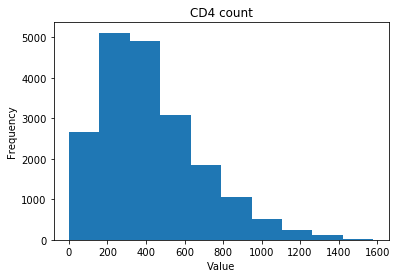

In [72]:
# positivity look at 10th and 90th percentiles
import matplotlib.pyplot as plt
myplot = plt.hist(df["L"])
plt.title("CD4 count")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Positivity

In [189]:
# simulate data
df = get_sim_data(T, k, gam, theta, n = 1000)

# get 20th and 80th percentile values for L (CD4 count)
p30_80 = np.percentile(df["L"], q = [30, 80])

# if L (CD4 count) falls below the 30th percentile at visit k,
# The doctor begins treatment. As a result there are no untreated
# patients with CD4 count below L20
# stay on treatment -> do within a group_by
df["Ls"] = df["L"] <= p30_80[0]
df["Ls"] = df.groupby(level="patid")['Ls'].cumsum()
df["A2"] = np.where(df['Ls'] > 0, 1, df["A"])

# if L (CD4 count) is above the 80th percentile then the patient never gets
# treatment, unless they subsequently get a lower CD4 count, in which case
# they may get treatment and then stay on that treatment, or they may not
# get treatment even at the lower level.
df["Ls"] = df["L"] < p30_80[1]
df["Ls2"] = (df["Ls"] == df["A"])
df["Ls2"] = df.groupby(level="patid")['Ls2'].cumsum()
df.head()

Y          L         U  A   Ts   d1   d3     L_100   Lav_100  \
patid visit                                                                 
0     0      0  460.20677  0.540011  0  5.0  0.0 -0.0  4.602068  3.023036   
      1      0  460.20677  0.567812  0  5.0  1.0 -0.0  4.602068  3.023036   
      2      0  460.20677  0.570659  0  5.0  2.0 -0.0  4.602068  3.023036   
      3      0  460.20677  0.544835  0  5.0  3.0 -0.0  4.602068  3.023036   
      4      0  460.20677  0.540442  0  5.0  4.0 -0.0  4.602068  3.023036   

             A_1    Ls  A2  Ls2  
patid visit                      
0     0      0.0  True   0  0.0  
      1      0.0  True   0  0.0  
      2      0.0  True   0  0.0  
      3      0.0  True   0  0.0  
      4      0.0  True   0  0.0

In [190]:
df.loc[(4, slice(None)), :]


Y           L         U  A   Ts   d1    d3     L_100   Lav_100  \
patid visit                                                                   
4     0      0  469.869407  0.583485  1  0.0  0.0   0.0  4.698694  3.379554   
      1      0  469.869407  0.577425  1  0.0  0.0   1.0  4.698694  3.379554   
      2      0  469.869407  0.647801  1  0.0  0.0   2.0  4.698694  3.379554   
      3      0  469.869407  0.569305  1  0.0  0.0   3.0  4.698694  3.379554   
      4      0  469.869407  0.556401  1  0.0  0.0   4.0  4.698694  3.379554   
      5      0  518.509056  0.591313  1  0.0  0.0   5.0  5.185091  3.379554   
      6      0  518.509056  0.536894  1  0.0  0.0   6.0  5.185091  3.379554   
      7      0  518.509056  0.539322  1  0.0  0.0   7.0  5.185091  3.379554   
      8      0  518.509056  0.524628  1  0.0  0.0   8.0  5.185091  3.379554   
      9      0  518.509056  0.540818  1  0.0  0.0   9.0  5.185091  3.379554   
      10     0  394.108998  0.516953  1  0.0  0.0  10.0  3.941090  3.379554   
      11     0  394.108998  0.559332  1  0.0  0.0  11.0  3.941090  3.379554   
      12     0  394.108998  0.586690  1  0.0  0.0  12.0  3.941090  3.379554   
      13     0  394.108998  0.564391  1  0.0  0.0  13.0  3.941090  3.379554   
      14     0  394.108998  0.604625  1  0.0  0.0  14.0  3.941090  3.379554   
      15     0  172.107560  0.677529  1  0.0  0.0  15.0  1.721076  3.379554   
      16     0  172.107560  0.751414  1  0.0  0.0  16.0  1.721076  3.379554   
      17     0  172.107560  0.732566  1  0.0  0.0  17.0  1.721076  3.379554   
      18     0  172.107560  0.676162  1  0.0  0.0  18.0  1.721076  3.379554   
      19     0  172.107560  0.644621  1  0.0  0.0  19.0  1.721076  3.379554   
      20     0    0.000000  0.560952  1  0.0  0.0  20.0  0.000000  3.379554   
      21     0    0.000000  0.621321  1  0.0  0.0  21.0  0.000000  3.379554   
      22     1    0.000000  0.596872  1  0.0  0.0  22.0  0.000000  3.379554   

             A_1    Ls  A2   Ls2  
patid visit                       
4     0      0.0  True   1   1.0  
      1      1.0  True   1   2.0  
      2      1.0  True   1   3.0  
      3      1.0  True   1   4.0  
      4      1.0  True   1   5.0  
      5      1.0  True   1   6.0  
      6      1.0  True   1   7.0  
      7      1.0  True   1   8.0  
      8      1.0  True   1   9.0  
      9      1.0  True   1  10.0  
      10     1.0  True   1  11.0  
      11     1.0  True   1  12.0  
      12     1.0  True   1  13.0  
      13     1.0  True   1  14.0  
      14     1.0  True   1  15.0  
      15     1.0  True   1  16.0  
      16     1.0  True   1  17.0  
      17     1.0  True   1  18.0  
      18     1.0  True   1  19.0  
      19     1.0  True   1  20.0  
      20     1.0  True   1  21.0  
      21     1.0  True   1  22.0  
      22     1.0  True   1  23.0